# Shape of decision-consistent biases by DDM

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm

sys.path.append('..')
from src import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/processed/behavior")
utils.download_dataset("data/outputs/behavior")
with open('../data/outputs/behavior/results_stimulus_specific_bias.pickle', 'rb') as f:
    results = pickle.load(f)
    
behavior  = pd.read_csv("../data/processed/behavior/behavior.csv")
behavior = behavior[(~np.isnan(behavior['choice'])) & (~np.isnan(behavior['error']))]

downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...
downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...


In [3]:
subid  = behavior.ID.to_numpy()
subids = np.unique(subid)
stim   = behavior.stim.to_numpy()
stims  = np.unique(stim)
timing = behavior.Timing.to_numpy()
dm     = 2 - behavior.choice.to_numpy()
ref    = behavior.ref.to_numpy()
error  = behavior.error.to_numpy()

---
## Behavior

In [4]:
errors = np.nan * np.zeros([2,24,2]) # EL, C/CW
stds   = np.nan * np.zeros([2,24,2]) # EL, C/CW

for i_t, v_t in enumerate([1,2]):
    for i_s, v_s in enumerate(stims):
        for i_dm in range(2):
            idx = (timing==v_t) & (stim==v_s) & (dm==i_dm) & (np.abs(ref)<5)
            errors[i_t,i_s,i_dm] = utils.circmean(error[idx])
            stds[i_t,i_s,i_dm]   = np.std(error[idx])/np.sqrt(np.sum(idx))

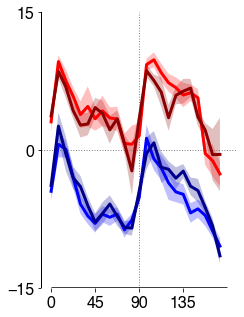

In [5]:
plt.figure()
ax = plt.gca()
utils.set_size([2.8,3.5])

plt.axvline(x=90, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.plot(stims, (errors)[1,:,0], color='blue',linewidth=3)
plt.plot(stims, (errors)[1,:,1], color='red',linewidth=3)
plt.plot(stims, (errors)[0,:,0], color='darkblue',linewidth=3)
plt.plot(stims, (errors)[0,:,1], color='darkred',linewidth=3)

plt.fill_between(x=stims, y1=(errors-stds)[0,:,0], y2=(errors+stds)[0,:,0], color='darkblue', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(errors-stds)[0,:,1], y2=(errors+stds)[0,:,1], color='darkred', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(errors-stds)[1,:,0], y2=(errors+stds)[1,:,0], color='blue', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(errors-stds)[1,:,1], y2=(errors+stds)[1,:,1], color='red', alpha=0.25, edgecolor="none")
plt.xlim([-10,190])
plt.ylim([-15,15])

utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-15,15), xticks=[0,45,90,135], yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/sfig4a_left.pdf',bbox_inches='tight')
plt.show()

In [6]:
errors = np.nan * np.zeros([len(subids),2]) # EL
dces   = np.nan * np.zeros([len(subids),2,2]) # EL, C/CW

for i_sub, v_sub in enumerate(subids):
    for i_t, v_t in enumerate([1,2]):
        idx = (subid==v_sub) & (timing==v_t) & (np.abs(ref)<5)
        errors[i_sub,i_t] = np.mean(error[idx] * (2*dm[idx]-1))
        
        for i_dm in range(2):
            idx = (subid==v_sub) & (timing==v_t) & (dm==i_dm) & (np.abs(ref)<5)
            dces[i_sub,i_t,i_dm] = np.mean(error[idx])

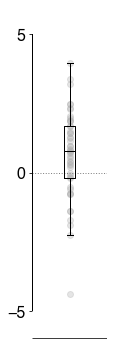

In [7]:
v_Ecw  = dces[:,0,0]
v_Eccw = dces[:,0,1]
v_Lcw  = dces[:,1,0]
v_Lccw = dces[:,1,1]

v_E, v_L = (v_Eccw-v_Ecw)/2., (v_Lccw-v_Lcw)/2.
plt.figure()
ax = plt.gca()
utils.set_size([1.4,3.8])
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

boxprops = dict(linestyle='-', linewidth=1, color='k')
flierprops = dict(marker='o', markersize=1, linestyle='none')
whiskerprops = dict(color='k')
capprops = dict(color='k')
medianprops = dict(linewidth=1, linestyle='-', color='k')

plt.scatter(1+np.random.normal(size=len(v_L))*0.001, v_L-v_E, color='darkgray', alpha=0.3 )
plt.boxplot(v_L-v_E, vert=True, showfliers=False, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,)
plt.xticks([],[])
plt.xlim([0.5,1.5])
plt.ylim([-6,6])

if utils.LABEL:
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    
utils.draw_publish_axis(ax, xrange=(0.5,1.5), yrange=(-5,5), xticks=None, yticks=[-5,0,5])
plt.savefig(f'{utils.DIR_FIGURE}/sfig4a_right.pdf',bbox_inches='tight')
plt.show()

---
## DDM

In [8]:
from src.model_ddm import model
sys.modules['model'] = model
model_path = '../models/ddm/'

In [9]:
models_full = {}
models_rdcd = {}

# full model
files  = sorted([f for f in os.listdir(model_path+'full') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'full/'+v_f, 'rb') as f:
        models_full[v_f[17:21]] = pickle.load(f)
    
# reduced model
files  = sorted([f for f in os.listdir(model_path+'reduced') if ('.pkl' in f)])
for v_f in files:
    with open(model_path+'reduced/'+v_f, 'rb') as f:
        models_rdcd[v_f[17:21]] = pickle.load(f)

In [10]:
def forward(model, params, data):
    # parameters
    if model.model == 'full':    
        w_K = params[0]*np.pi/90.
    w_E, w_P, w_D, w_r, w_b = [p*np.pi/90. for p in params[(-7):(-2)]]
    lam, c = params[(-2):]

    # efficient encoding 
    kappa = model.kappa
    p,F = model.efficient_encoding(c)
    p_e = np.sqrt(1./np.clip(w_E,model.eps,None))
    F_interp = model.F_interp(F)
    P0  = np.exp(p_e*(np.cos((F.reshape(-1,1)-F_interp(data['stim'])))-1.))    
    P0  = P0*p.reshape(-1,1)
    P0 /= P0.sum(axis=0,keepdims=True)
    
    # transition matrices
    Lp = model.Hdiffu/2.*np.power(w_P,2) # production transition
    if model.model == 'reduced':    
        L = model.Hdiffu/2.*np.power(w_D,2)
    elif model.model == 'full':
        L = model.Hdiffu/2.*np.power(w_D,2) - model.Hdrift@np.diag(kappa*w_K)

    # density propagation
    P  = [np.zeros_like(P0)*np.nan, np.zeros_like(P0)*np.nan] # CW, CCW
    PE = [np.zeros_like(P0) * np.nan, np.zeros_like(P0) * np.nan] 
    PL = [np.zeros_like(P0) * np.nan, np.zeros_like(P0) * np.nan]
    L1 = [L*model.delay[0][0], L*model.delay[0][1]] # 1st delay transitions for Early and Late conditions
    L2 = [L*model.delay[1][0], L*model.delay[1][1]] # 2nd delay transitions for Early and Late conditions

    for i_delay, delay in enumerate(model.delay_condition):
        _P      = expm(L1[i_delay]) @ P0
        _P_cw   = (1.-lam) * model.mask_cw * _P + lam * model.mask_ccw * _P
        _P_ccw  = lam * model.mask_cw * _P + (1.-lam) * model.mask_ccw * _P
        for r in model.relative_reference:
            idx = (data['delay']==delay) & (data['relref']==r)
            P[0][:, idx] = expm(Lp) @ expm(L2[i_delay]) @ expm(model.Hdrift*(-w_b*(np.abs(r)<model.near_cutoff)-r*w_r)) @ _P_cw[:,idx]
            P[1][:, idx] = expm(Lp) @ expm(L2[i_delay]) @ expm(model.Hdrift*( w_b*(np.abs(r)<model.near_cutoff)-r*w_r)) @ _P_ccw[:,idx]
               
            #
            if delay == 1:
                PE[0][:,idx] = _P_cw[:,idx]
                PE[1][:,idx] = _P_ccw[:,idx]
            if delay == 2:
                PL[0][:,idx] = _P_cw[:,idx]
                PL[1][:,idx] = _P_ccw[:,idx]

    # Make nonnegative
    P[0][P[0]<0] = 0.; P[1][P[1]<0] = 0.
    PE[0][PE[0]<0] = 0.; PE[1][PE[1]<0] = 0.
    PL[0][PL[0]<0] = 0.; PL[1][PL[1]<0] = 0.

    # 
    sums  = (P[0]+P[1]).sum(axis=0,keepdims=True)
    P[0] /= sums
    P[1] /= sums
    sums  = (PE[0]+PE[1]).sum(axis=0,keepdims=True)
    PE[0] /= sums
    PE[1] /= sums
    sums  = (PL[0]+PL[1]).sum(axis=0,keepdims=True)
    PL[0] /= sums
    PL[1] /= sums

    return PE, PL, P

In [11]:
# may take about 2mins
dcbs    = np.zeros((2,50,2,24,2)) * np.nan # E-L / CW-CCW
dcb_res = np.zeros((2,50,2,2)) * np.nan # E-L / CW-CCW

for i_models, models in enumerate([models_full, models_rdcd]):
    for i_model, (n_model, model) in enumerate(models.items()):
        # average densities over diffferent stimuli and choices
        errsD = np.zeros((2,5,96,24,2)) * np.nan
        errsE = np.zeros((2,5,96,24,2)) * np.nan

        fitted_params = model.fitted_params.copy()
        _stim = np.linspace(0,180,num=24,endpoint=False)

        for i_d, v_d in enumerate([1,2]):
            _delay  = np.ones(24) * v_d
            for i_r, v_r in enumerate([-21,-4,0,4,21]):
                _relref = np.repeat(v_r, 24)
                _ref    = (_stim + v_r - 90.) % (180.) - 90.
                _data   = {
                    'deg' : {
                        'stim': _stim,
                        'ref' : _ref
                    },
                    'relref': _relref,
                    'delay' : _delay
                }
                _data = model.convert_unit(_data)
                model.gen_mask(_data)
                PE, PL, P = forward(model, fitted_params, _data)
                errsD[i_d,i_r,:,:,0] = np.stack([np.roll(p,-i*4) for i,p in enumerate([PE,PL][i_d][0].T)],axis=-1)
                errsD[i_d,i_r,:,:,1] = np.stack([np.roll(p,-i*4) for i,p in enumerate([PE,PL][i_d][1].T)],axis=-1)
                errsE[i_d,i_r,:,:,0] = np.stack([np.roll(p,-i*4) for i,p in enumerate(P[0].T)],axis=-1)
                errsE[i_d,i_r,:,:,1] = np.stack([np.roll(p,-i*4) for i,p in enumerate(P[1].T)],axis=-1)

        #
        s = np.sin(model.m)
        c = np.cos(model.m)
        s,c = [errsE[:,1:4].mean(axis=1).transpose((0,2,3,1)) @ k for k in [s,c]]
        bb = np.arctan2(s,c)
        dcbs[i_models,i_model] = bb * 90/np.pi
        
        s = np.sin(model.m)
        c = np.cos(model.m)
        s,c = [errsE[:,1:4].mean(axis=(1,3)).transpose((0,2,1)) @ k for k in [s,c]]
        bb = np.arctan2(s,c)
        dcb_res[i_models,i_model] = bb * 90/np.pi

In [12]:
mdcbs = np.mean(dcbs,axis=1)
sdcbs = np.std(dcbs,axis=1)/np.sqrt(50)

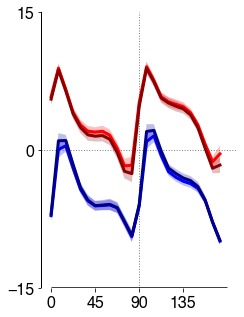

In [13]:
plt.figure()
ax = plt.gca()
utils.set_size([2.8,3.5])

plt.axvline(x=90, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.plot(stims, mdcbs[0,1,:,1], color='blue',linewidth=3)
plt.plot(stims, mdcbs[0,1,:,0], color='red',linewidth=3)
plt.plot(stims, mdcbs[0,0,:,1], color='darkblue',linewidth=3)
plt.plot(stims, mdcbs[0,0,:,0], color='darkred',linewidth=3)

plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[0,0,:,1], 
                          y2=(mdcbs+sdcbs)[0,0,:,1], color='darkblue', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[0,0,:,0], 
                          y2=(mdcbs+sdcbs)[0,0,:,0], color='darkred', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[0,1,:,1], 
                          y2=(mdcbs+sdcbs)[0,1,:,1], color='blue', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[0,1,:,0], 
                          y2=(mdcbs+sdcbs)[0,1,:,0], color='red', alpha=0.25, edgecolor="none")

plt.xlim([-10,190])
plt.ylim([-15,15])

utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-15,15), xticks=[0,45,90,135], yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/sfig4b_left.pdf',bbox_inches='tight')
plt.show()

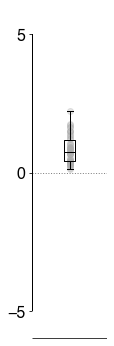

In [14]:
v_E, v_L = (dcb_res[0,:,0,0]-dcb_res[0,:,0,1])/2., \
           (dcb_res[0,:,1,0]-dcb_res[0,:,1,1])/2.

plt.figure()
ax = plt.gca()
utils.set_size([1.4,3.8])
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.scatter(1+np.random.normal(size=len(v_L))*0.001, v_L-v_E, color='darkgray', alpha=0.3 )
plt.boxplot(v_L-v_E, vert=True, showfliers=False, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,)
plt.xticks([],[])
plt.xlim([0.5,1.5])
plt.ylim([-6,6])

if utils.LABEL:
    plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")
utils.draw_publish_axis(ax, xrange=(0.5,1.5), yrange=(-5,5), xticks=None, yticks=[-5,0,5])
plt.savefig(f'{utils.DIR_FIGURE}/sfig4b_right.pdf',bbox_inches='tight')
plt.show()

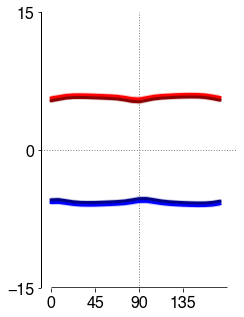

In [15]:
plt.figure()
ax = plt.gca()
utils.set_size([2.8,3.5])

plt.axvline(x=90, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.plot(stims, mdcbs[1,1,:,1], color='blue',linewidth=3)
plt.plot(stims, mdcbs[1,1,:,0], color='red',linewidth=3)
plt.plot(stims, mdcbs[1,0,:,1], color='darkblue',linewidth=3)
plt.plot(stims, mdcbs[1,0,:,0], color='darkred',linewidth=3)

plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[1,0,:,1], 
                          y2=(mdcbs+sdcbs)[1,0,:,1], color='darkblue', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[1,0,:,0], 
                          y2=(mdcbs+sdcbs)[1,0,:,0], color='darkred', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[1,1,:,1], 
                          y2=(mdcbs+sdcbs)[1,1,:,1], color='blue', alpha=0.25, edgecolor="none")
plt.fill_between(x=stims, y1=(mdcbs-sdcbs)[1,1,:,0], 
                          y2=(mdcbs+sdcbs)[1,1,:,0], color='red', alpha=0.25, edgecolor="none")

plt.xlim([-10,190])
plt.ylim([-15,15])

utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-15,15), xticks=[0,45,90,135], yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/sfig4c_left.pdf',bbox_inches='tight')
plt.show()

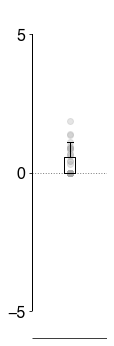

In [16]:
v_E, v_L = (dcb_res[1,:,0,0]-dcb_res[1,:,0,1])/2., \
           (dcb_res[1,:,1,0]-dcb_res[1,:,1,1])/2.

plt.figure()
ax = plt.gca()
utils.set_size([1.4,3.8])
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.scatter(1+np.random.normal(size=len(v_L))*0.001, v_L-v_E, color='darkgray', alpha=0.3 )
plt.boxplot(v_L-v_E, vert=True, showfliers=False, notch=False, boxprops=boxprops, whiskerprops=whiskerprops,capprops=capprops, flierprops=flierprops, medianprops=medianprops,)
plt.xticks([],[])
plt.xlim([0.5,1.5])
plt.ylim([-6,6])

utils.draw_publish_axis(ax, xrange=(0.5,1.5), yrange=(-5,5), xticks=None, yticks=[-5,0,5])
plt.savefig(f'{utils.DIR_FIGURE}/sfig4c_right.pdf',bbox_inches='tight')
plt.show()